# analysis of 10x Visium data
In this practical, we will get to know the Python ecosystem for (spatial) data. We will work on a mouse brain data set from [Kleshchevnikov et al., 2020](https://doi.org/10.1101/2020.11.15.378125). You can download the data [here](https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_wo_cloupe_data.zip) (we will used only the ST8059048 sample).

## libraries and first impressions
Let's start by loading the required packages. [NumPy](https://www.numpy.org), [SciPy](https://www.scipy.org), [Matplotlib](https://matplotlib.org/) (and arguably [seaborn](https://seaborn.pydata.org/)) are the pillars of the scientific Python stack and belong on every scientist's computer. [AnnData](https://anndata.readthedocs.io) provides a container object that can hold the raw data, associated metadata, and transformed/analyzed data, such as pairwise distance matrices or embeddings. [ScanPy](https://scanpy.readthedocs.io) is the Python equivalent to Seurat. It works on AnnData objects and provides many preprocessing, analysis, and visualization methods. [SquidPy](https://squidpy.readthedocs.io) is a new package geared towards spatial data. It also works on AnnData objects and is focused on analysis of graphs and images. It also provides interactive visualization using [Napari](https://napari.org). [SpatialDE](https://github.com/ilia-kats/SpatialDE) accepts AnnData objects as well and can detect spatially variable genes as well as perform segmentation of tissue regions taking both gene expression and spatial coordinates into account.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import squidpy as sq
import scanpy as sc

plt.rcParams["figure.figsize"] = (8, 8)

import sys
sys.path.append("../../../../software/SpatialDE/")
import SpatialDE

ScanPy provides a handy function to read Visium data as it comes out of the 10x pipeline.

In [2]:
adata = sc.read_visium("data/ST8059048")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


You can think of AnnData as a spots x genes matrix (spots are called `obs` and genes are called `vars` in AnnData) together with some metadata.

In [3]:
adata

AnnData object with n_obs × n_vars = 2987 × 31053
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Each observation and each gene can have associated metadata, which are stored in Pandas dataframes.

In [4]:
adata.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGCTTTCAGAAG-1,1,43,9
AAACAGGGTCTATATT-1,1,47,13
...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64
TTGTTGTGTGTCAAGA-1,1,31,77
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30


In [5]:
adata.var

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,mm10-3.0.0_premrna
Gm1992,ENSMUSG00000089699,Gene Expression,mm10-3.0.0_premrna
Gm37381,ENSMUSG00000102343,Gene Expression,mm10-3.0.0_premrna
Rp1,ENSMUSG00000025900,Gene Expression,mm10-3.0.0_premrna
Sox17,ENSMUSG00000025902,Gene Expression,mm10-3.0.0_premrna
...,...,...,...
AC168977.1,ENSMUSG00000079808,Gene Expression,mm10-3.0.0_premrna
AC149090.1,ENSMUSG00000095041,Gene Expression,mm10-3.0.0_premrna
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,mm10-3.0.0_premrna
Vmn2r122,ENSMUSG00000096730,Gene Expression,mm10-3.0.0_premrna


## quality control and preprocessing
Some gene names are not unique, as Scanpy warned us when reading the data. This can create problems down the road, as genes cannot be uniquely identified. We start by creating unique gene names and performing some quality control.

In [6]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

To decide on how to filter out low-quality spots, we plot both histograms of total reads per spot as well as number of detected genes per spot (this is the somewhat confusingly named `n_genes_by_counts` variable).

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Count'>

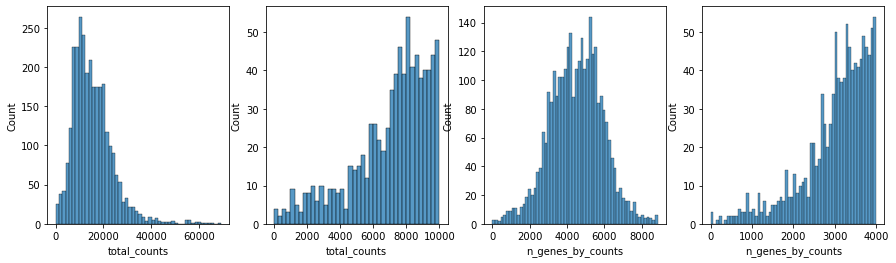

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

Based on the histograms we filter out spots with low read counts or low number of detected genes. We also filter out spots with a high proportion of mitochondrial reads and we remove genes that were detected in less than 10 spots.

In [8]:
sc.pp.filter_cells(adata, min_counts=4500)
sc.pp.filter_cells(adata, min_genes=1500)
sc.pp.filter_genes(adata, min_cells=10)

To properly visualize counts, it is advisable to first normalize the read count in each spot by the total number of reads in this spot, followed by a log transform. However, we do not want to lose the original count data (we will need them later). Fortunately, AnnData has a concept of layers. This means that you can store multiple data matrices for a data set, so we save a copy of our original count matrix to a layer and proceed with normalization.

In [9]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Visualizing spatial data
We can now plot the total number of reads per spot. ScanPy's `spatial` plotting function will put the H&E stained tissue image underneath the spots.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


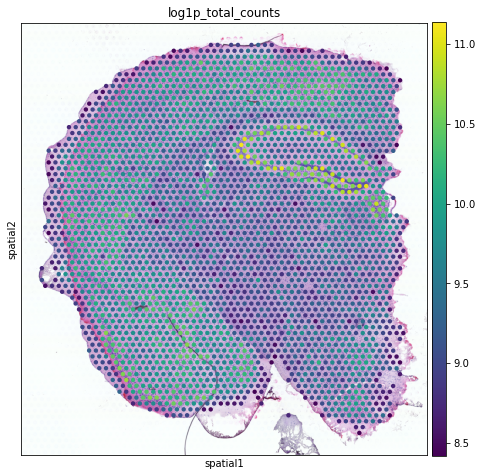

In [10]:
sc.pl.spatial(adata, color="log1p_total_counts")

We can also look at individual genes. For example, let's look at expression of GABA and dopamine receptors. Gabbr1 is the GABA type B receptor subunit 1 and Drd1 is the D(1a) dopamine receptor.

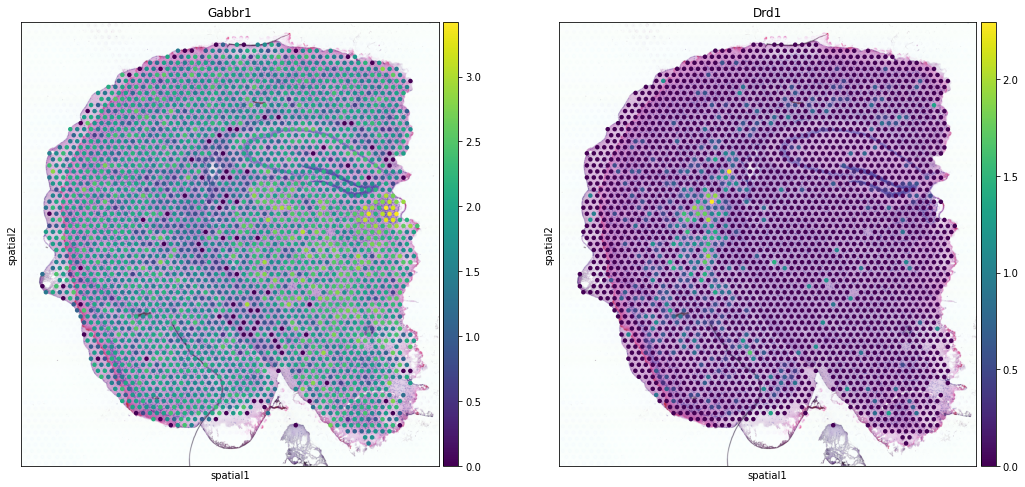

In [11]:
sc.pl.spatial(adata, color=["Gabbr1", "Drd1"])

Suppose we now want to select this cluster of spots with high dopamine receptor expression. Instead of tediously correlating spot indices with coordinates, we can use SquidPy/Napari to interactively select those spots.

In [12]:
image = sq.im.ImageContainer(adata.uns["spatial"]["spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna"]["images"]["hires"], scale=adata.uns["spatial"]["spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna"]["scalefactors"]["tissue_hires_scalef"])
viewer = image.interactive(adata)

In the viewer window, first select Drd1 from the gene list by double-clicking. Then add a shape layer and rename it to Dopamine_receptor. Add a polygon selecting Drd1-expressing spots and press Shift+E. This will save a mask of the spots within the polygon to `.obs.Dopamine_receptor_shapes`.

In [13]:
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts,n_genes
AAACAAGTATCTCCCA-1,1,50,102,4678,8.450840,14284.0,9.566965,27.457295,32.812938,39.897788,52.856343,2847.0,7.954372,19.931393,14284.0,4678
AAACACCAATAACTGC-1,1,59,19,3549,8.174703,9951.0,9.205529,37.061602,42.337454,49.110642,60.586876,2764.0,7.924796,27.776104,9951.0,3549
AAACAGAGCGACTCCT-1,1,14,94,6779,8.821732,32155.0,10.378354,23.784792,29.830508,37.860364,51.397916,4866.0,8.490233,15.132950,32155.0,6779
AAACAGCTTTCAGAAG-1,1,43,9,3108,8.042056,7935.0,8.979165,32.917454,39.054820,46.389414,59.206049,1906.0,7.553287,24.020164,7935.0,3108
AAACAGGGTCTATATT-1,1,47,13,4515,8.415382,14483.0,9.580800,30.994960,36.415107,43.506180,56.031209,3190.0,8.068089,22.025824,14483.0,4515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,8457,9.042868,65866.0,11.095393,17.673762,24.381320,33.152157,48.190265,3352.0,8.117611,5.089120,65866.0,8457
TTGTTGTGTGTCAAGA-1,1,31,77,3464,8.150468,8785.0,9.080914,27.137166,33.249858,41.343199,55.310188,1586.0,7.369601,18.053501,8785.0,3464
TTGTTTCACATCCAGG-1,1,58,42,5457,8.604838,19956.0,9.901335,23.872520,29.695330,37.748046,51.638605,2988.0,8.002694,14.972940,19956.0,5457
TTGTTTCATTAGTCTA-1,1,60,30,5300,8.575651,18351.0,9.817493,24.892376,30.477903,38.194104,51.670209,3122.0,8.046550,17.012697,18351.0,5300


## clustering spatial data
Suppose we want to create a UMAP plot of our data to check if the dopamine-expressing spots are nicely clustered together. The classical workflow consists of selecting variable genes, followed by PCA, k-nearest-neighbors, and finally UMAP. However, we have additional information available, namely spatial coordinates. So instead of just using highly variable genes, we will use genes that are spatially variable. This means that instead of varying randomly across spots, they follow a smooth pattern of variation across the tissue slice (plus some noise). SpatialDE can detect such spatially variable genes, but on large data sets like this ones you ideally would run this on a GPU to get a decent run time. We therefore have precomputed the spatially variable genes for you. You can download the file <span style="color:red;font-size:xx-large">here</span>

In [14]:
spatially_variable = pd.read_pickle("data/ST8059048_svg_full.pkl")
spatially_variable

,gene,time,kappa,nu,U_tilde,e_tilde,I_tilde,pval,padj,total_counts
0,Xkr4,4.575402,165.971038,17.036499,1.397586e+04,2827.565490,9.385880e+05,7.014123e-11,2.765955e-10,816.0
1,Sox17,0.027742,30.547828,16.417408,5.979530e+02,501.516158,3.064046e+04,2.630273e-01,3.147789e-01,131.0
2,Mrpl15,0.066843,643.617758,15.840952,1.053182e+04,10195.517969,1.312403e+07,4.167195e-01,4.654604e-01,2497.0
3,Tcea1,0.078515,490.561791,15.840952,8.577739e+03,7770.965741,7.624278e+06,3.444157e-01,3.960359e-01,1903.0
4,Rgs20,0.015914,250.724726,17.495244,3.661584e+04,4386.490378,2.199603e+06,0.000000e+00,0.000000e+00,1400.0
...,...,...,...,...,...,...,...,...,...,...
12677,mt-Cytb,0.014791,10150.168478,20.032541,4.055169e+06,203333.663036,4.127742e+09,0.000000e+00,0.000000e+00,587548.0
12678,Vamp7,0.072417,359.315564,15.840955,1.463586e+04,5691.901540,4.090378e+06,5.584431e-04,1.191483e-03,1394.0
12679,Spry3,0.112053,94.855159,15.840952,2.252656e+03,1502.596012,2.850580e+05,9.069494e-02,1.249531e-01,368.0
12680,AC149090.1,0.017502,519.614113,17.241734,4.828150e+04,8959.048492,9.310496e+06,2.221223e-12,9.516741e-12,2785.0


We select 2000 most highly expressed spatially variable genes and use those for the PCA.

In [15]:
vargenes = spatially_variable[spatially_variable.padj < 0.001].sort_values("total_counts", ascending=False).gene[:2000]

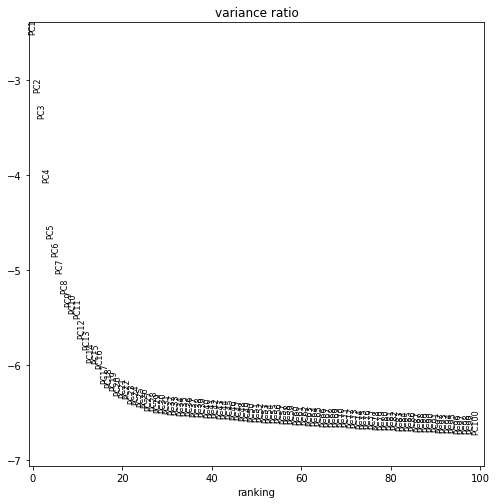

In [16]:
adata_variable = adata[:, vargenes]
sc.pp.regress_out(adata_variable, ['total_counts'])
sc.pp.pca(adata_variable, n_comps=100)
sc.pl.pca_variance_ratio(adata_variable, log=True, n_pcs=100)

We create a k-nearest-neighbors in the PCA space and use it to create a UMAP, which will be colored by whether a spot belongs to our set of spots with high dopamine receptor expression.

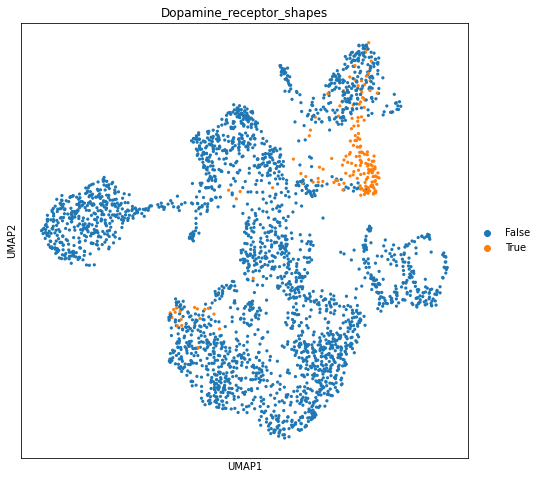

In [17]:
sc.pp.neighbors(adata_variable, n_neighbors=20, n_pcs=80)
sc.tl.umap(adata_variable)
sc.pl.umap(adata_variable, color="Dopamine_receptor_shapes")

So the dopamine expressing cells are located close together in gene expression space, which suggests that this is a brain region that responds to dopamine. Suppose we now want segment our entire data set into distinct regions. We could of course do what we just did: manually look through lots of genes and manually select the corresponding regions. However, that approach is tedious, irreproducible, and can potentiall overlook things. The development version of SpatialDE implements a segmentation method that groups spots by their expression, but encourages the clusters to be spatially smooth, i.e. neighboring spots should belong to the same cluster. This method is probabilistically motivated and works on raw counts, so we let it loose on the `counts` layer that we created previously.

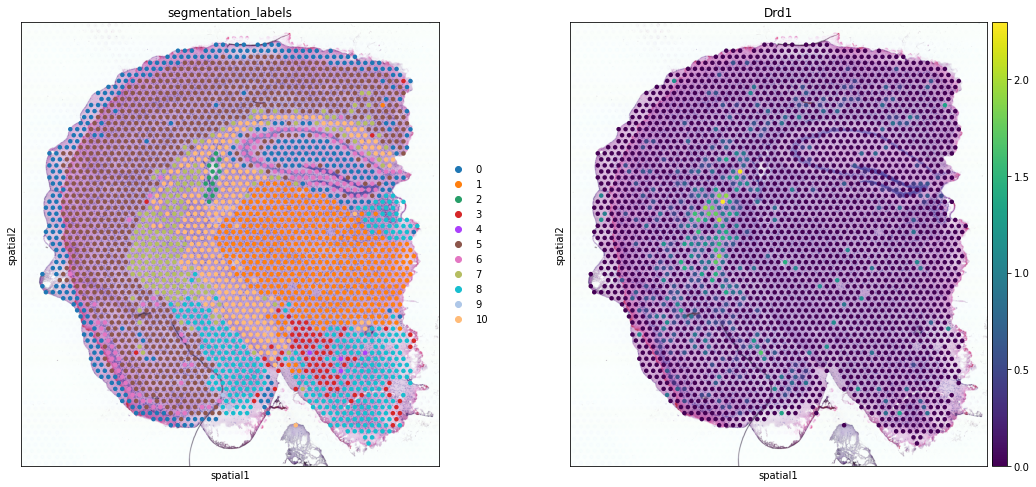

In [18]:
segmentation, _ = SpatialDE.tissue_segmentation(adata, genes=vargenes, layer="counts", rng=np.random.default_rng(seed=42))
sc.pl.spatial(adata, color=["segmentation_labels", "Drd1"])

As we can see, our dopamine-receptor-expressing spots are all clustered into the same cluster, but we also uncover distinct clusters in other brain regions. We can compare SpatialDE's results to a standard Leiden clustering, run on the k-nearest-neighbors graph we created previously.

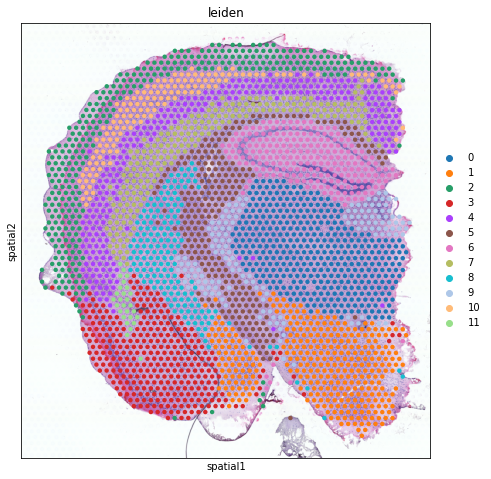

In [19]:
sc.tl.leiden(adata_variable, random_state=42)
sc.pl.spatial(adata_variable, color=["leiden"])

Leiden seems to resolve some areas better than SpatialDE, e.g. the layered structure of the isocortex, but some worse, e.g. the hippocampus. We can look at UMAPs colored by the two segmentations:

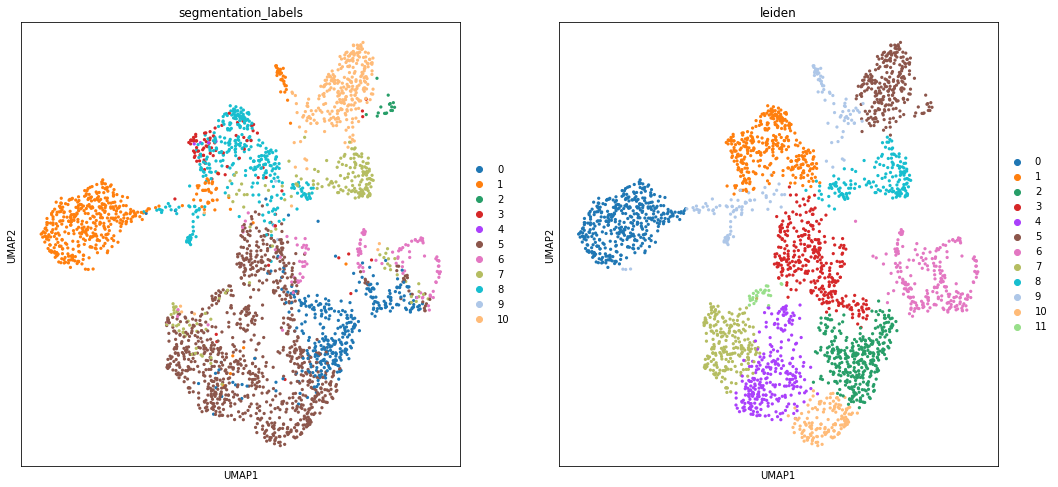

In [20]:
adata_variable.obs["segmentation_labels"] = adata.obs.segmentation_labels
sc.pl.umap(adata_variable, color=["segmentation_labels", "leiden"])

As expected, Leiden clusters correspond solely to distance in gene expression space. The hippocampus in particular looks like one cluster in gene expression space, possibly because the number of spots covering pyramidal neurons is so low.

We can increase SpatialDE's resolution by tweeking the spatial smoothness penalty. With reduced penalty (corresponding to a larger `smoothness_factor`), SpatialDE also recovers the layered structure of the isocortex, plus some additional details.

In [21]:
segmentation, _ = SpatialDE.tissue_segmentation(adata, genes=vargenes, layer="counts", rng=np.random.default_rng(seed=42), params=SpatialDE.TissueSegmentationParameters(smoothness_factor=5))

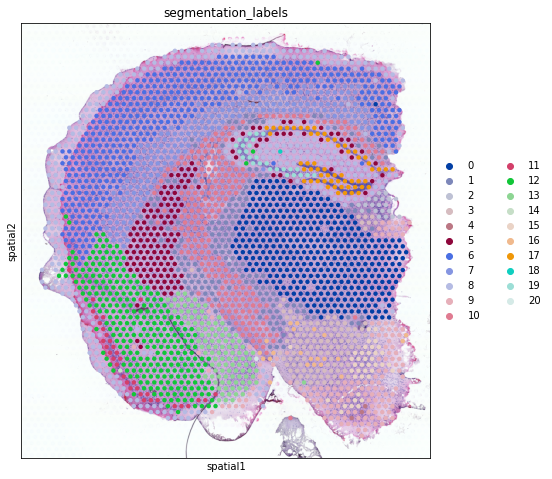

In [22]:
sc.pl.spatial(adata, color="segmentation_labels")

## extracting image features
Sometimes, one would like to include features features from the corresponding tissue images in one's analysis. SquidPy contains several functions that can extract classical computer vision features from an image, but we will use a different approach here. We will use a neural network, pre-trained to classify the ImageNet data set, without its top classification layer. The neuron activations of the second-to-last layer (i.e. the layer immediately preceding the classification layer) will be our features.

In [23]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

inputs = tf.keras.layers.Input(shape=next(iter(image.generate_spot_crops(adata,as_array="image", spot_scale=1.5))).shape)
resnet = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_tensor=inputs, pooling="avg")
resnet.compile()

SquidPy provides a handy function to generate image crops surrounding each spot.

In [24]:
topredict = np.stack(tuple(image.generate_spot_crops(adata, as_array="image", spot_scale=1.5)), axis=0)
features = resnet(topredict).numpy()

In [25]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
features.shape

(2871, 2048)

In [27]:
np.sum(features > 0)

93616

In [28]:
features[features > 0]

array([1.9342299 , 0.00362249, 0.11912923, ..., 0.2424451 , 0.37151092,
       0.15990606], dtype=float32)

In [29]:
features = sparse.csr_matrix(features)

## working with multimodal data
We could force the features matrix into our original AnnData object, e.g. by using the `obsm` slot, but that wouldn't really be useful. Instead, we can create a second AnnData object holding the image features, and group the two AnnData objects together. For this, we will use [muon](https://muon.readthedocs.io), a new package to make working with multi-modal data sets easier.

In [30]:
import muon as mu
import anndata as ad
features = ad.AnnData(X=features, obs=pd.DataFrame(index=adata.obs_names))
mu.set_options(display_style="html")

In [31]:
multim = mu.MuData({"visium": adata, "resnet_features": features})

In [32]:
multim

visium:in_tissue,int64,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
visium:array_row,int64,"50,59,14,43,47,61,42,52,65,37,35,65,67,66,45,45,..."
visium:array_col,int64,"102,19,94,9,13,97,28,42,83,19,79,91,59,70,67,19,..."
visium:n_genes_by_counts,int32,"4678,3549,6779,3108,4515,5784,6334,6843,3749,6421,..."
visium:log1p_n_genes_by_counts,float64,"8.45,8.17,8.82,8.04,8.42,8.66,8.75,8.83,8.23,8.77,..."
visium:total_counts,float32,"14284.00,9951.00,32155.00,7935.00,14483.00,..."
visium:log1p_total_counts,float32,"9.57,9.21,10.38,8.98,9.58,9.94,10.22,10.32,9.22,..."
visium:pct_counts_in_top_50_genes,float64,"27.46,37.06,23.78,32.92,30.99,21.15,22.31,20.03,..."
visium:pct_counts_in_top_100_genes,float64,"32.81,42.34,29.83,39.05,36.42,27.35,28.39,26.15,..."
visium:pct_counts_in_top_200_genes,float64,"39.90,49.11,37.86,46.39,43.51,35.74,36.50,34.56,..."
visium:pct_counts_in_top_500_genes,float64,"52.86,60.59,51.40,59.21,56.03,50.37,50.51,48.59,..."


## exercise
Muon provides a multimodal version of the Leiden clustering algorithm. See if you can get better results by including image features in the clustering. You should also try to use Muon's weighted nearest neighbors implementation to generate UMAPs based on both gene expression and image features. Also experiment with SquidPy's other image features and compare the clusterings.